# Imports and helper functions

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Libraries to define the required functions
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from pmdarima.model_selection import train_test_split as time_train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [ ]:
def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MAE
        - MSE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MAE, MSE, RMSE, MAPE and R² 
    '''    
    print('Evaluation metric results: ')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error_func(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def Augmented_Dickey_Fuller_Test_func(timeseries , column_name):
    '''
    Calculates statistical values whether the available data are stationary or not 
    
    Args:
        series (float64): Values of the column for which stationarity is to be checked, numpy array of floats 
        column_name (str): Name of the column for which stationarity is to be checked
    
    Returns:
        p-value that indicates whether the data are stationary or not
    ''' 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    adfTest = adfuller(timeseries, autolag='AIC')
    dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key, value in adfTest[4].items():
       dfResults['Critical Value (%s)'%key] = value
    print (dfResults)
    if adfTest[1] <= 0.05:
        print()
        print("Conclusion:")
        print("Reject the null hypothesis")
        print('\033[92m' + "Data is stationary" + '\033[0m')
    else:
        print()
        print("Conclusion:")
        print("Fail to reject the null hypothesis")
        print('\033[91m' + "Data is non-stationary" + '\033[0m')

In [ ]:
def cointegration_test_func(df): 
    '''
    Test if there is a long-run relationship between features
    
    Args:
        dataframe (float64): Values of the columns to be checked, numpy array of floats 
    
    Returns:
        True or False whether a variable has a long-run relationship between other features
    ''' 
    johansen_cointegration_test = coint_johansen(df,-1,5)
    c = {'0.90':0, '0.95':1, '0.99':2}
    traces = johansen_cointegration_test.lr1
    cvts = johansen_cointegration_test.cvt[:, c[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column_Name  >  Test_Stat  >  C(95%)  =>  Signif  \n', '--'*25)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '  >  ', 
              adjust(round(trace,2), 9), "  >  ", 
              adjust(cvt, 8), '  => ' , 
              trace > cvt)

In [ ]:
def inverse_diff_func(actual_df, pred_df):
    '''
    Transforms the differentiated values back
    
    Args:
        actual dataframe (float64): Values of the columns, numpy array of floats 
        predicted dataframe (float64): Values of the columns, numpy array of floats 
    
    Returns:
        Dataframe with the predicted values
    '''
    df_temp = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_temp[str(col)+'_inv_diff'] = actual_df[col].iloc[-1] + df_temp[str(col)].cumsum()
    return df_temp

# Model

In [ ]:
df_raw = pd.read_csv("/content/exchange_rate.csv").set_index('date')

In [ ]:
df_raw

,0,1,2,3,4,5,6,OT
date,,,,,,,,
1990/1/1 0:00,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,0.593000
1990/1/2 0:00,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,0.594000
1990/1/3 0:00,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,0.597300
1990/1/4 0:00,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,0.597000
1990/1/5 0:00,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.527426,0.598500
...,...,...,...,...,...,...,...,...
2010/10/6 0:00,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.688565,0.690846
2010/10/7 0:00,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.690288,0.695701
2010/10/8 0:00,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.691419,0.695943


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 1990/1/1 0:00 to 2010/10/10 0:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7588 non-null   float64
 1   1       7588 non-null   float64
 2   2       7588 non-null   float64
 3   3       7588 non-null   float64
 4   4       7588 non-null   float64
 5   5       7588 non-null   float64
 6   6       7588 non-null   float64
 7   OT      7588 non-null   float64
dtypes: float64(8)
memory usage: 791.6+ KB


In [ ]:
df_raw.describe()

,0,1,2,3,4,5,6,OT
count,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000,7588.000000
mean,0.776974,1.634105,0.821811,0.848146,0.142833,0.009343,0.669673,0.654418
std,0.136620,0.161544,0.117123,0.168874,0.023996,0.001458,0.082836,0.115292
min,0.483297,1.211534,0.618582,0.548617,0.109292,0.006254,0.523834,0.393153
25%,0.701422,1.532887,0.727901,0.696864,0.120814,0.008331,0.593287,0.566000
50%,0.761377,1.606574,0.811582,0.813959,0.145212,0.009151,0.662767,0.669187
75%,0.873477,1.707646,0.920394,1.014018,0.159948,0.009995,0.731835,0.734901
max,1.102536,2.109000,1.091524,1.374079,0.237954,0.013202,0.832556,0.882379


# EDA

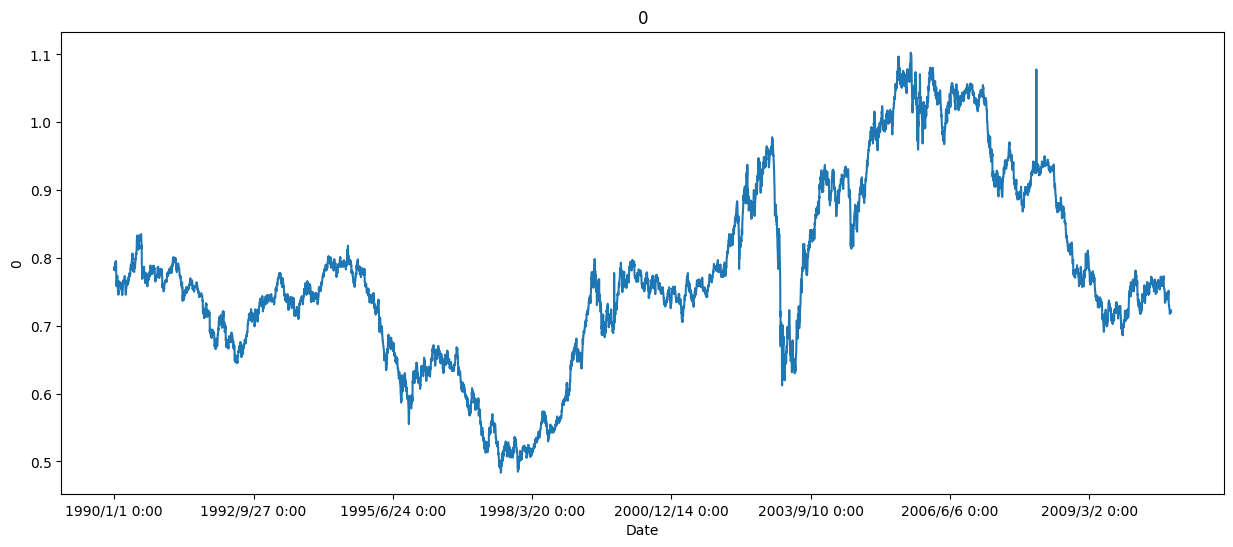

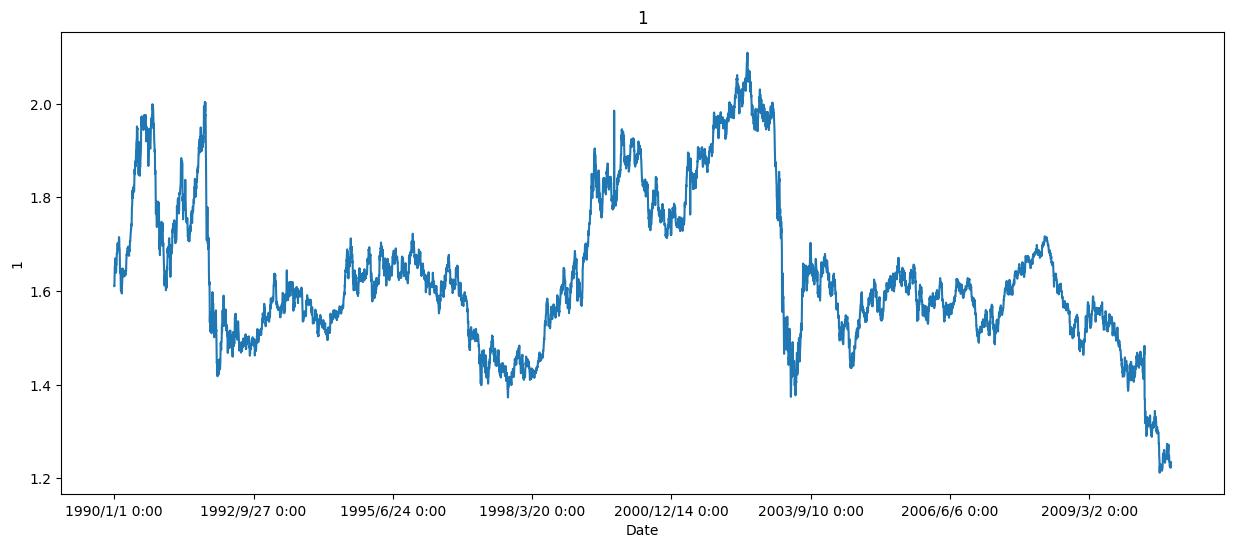

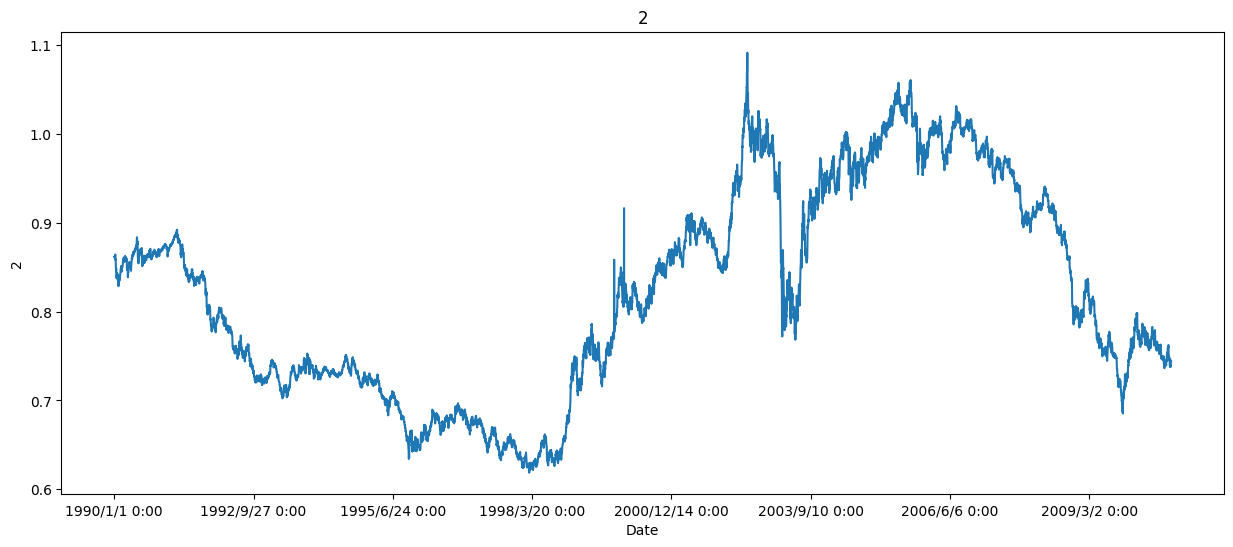

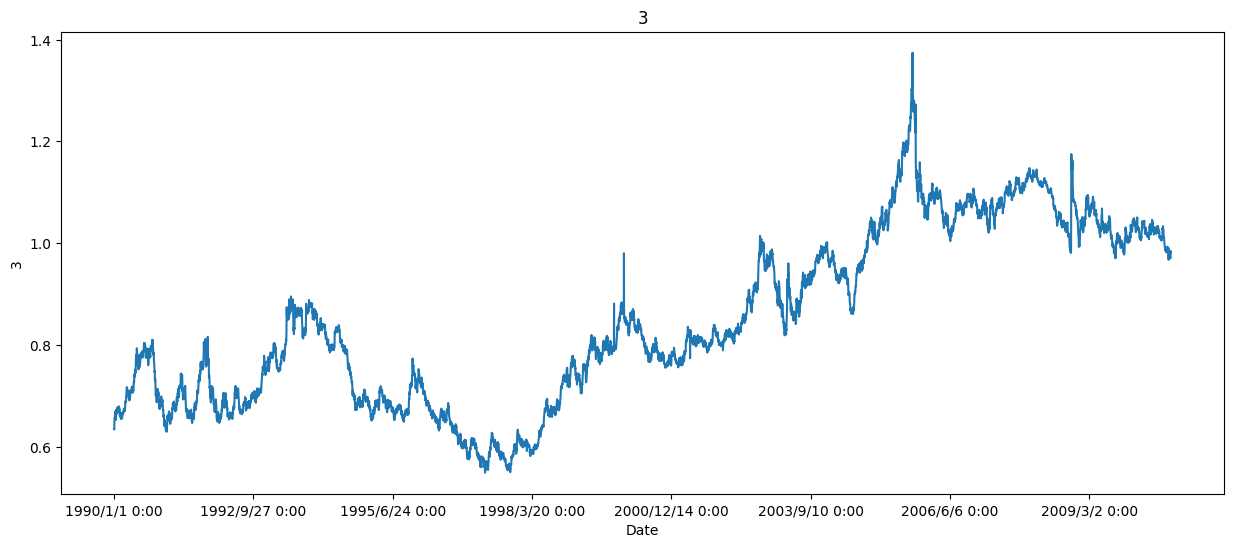

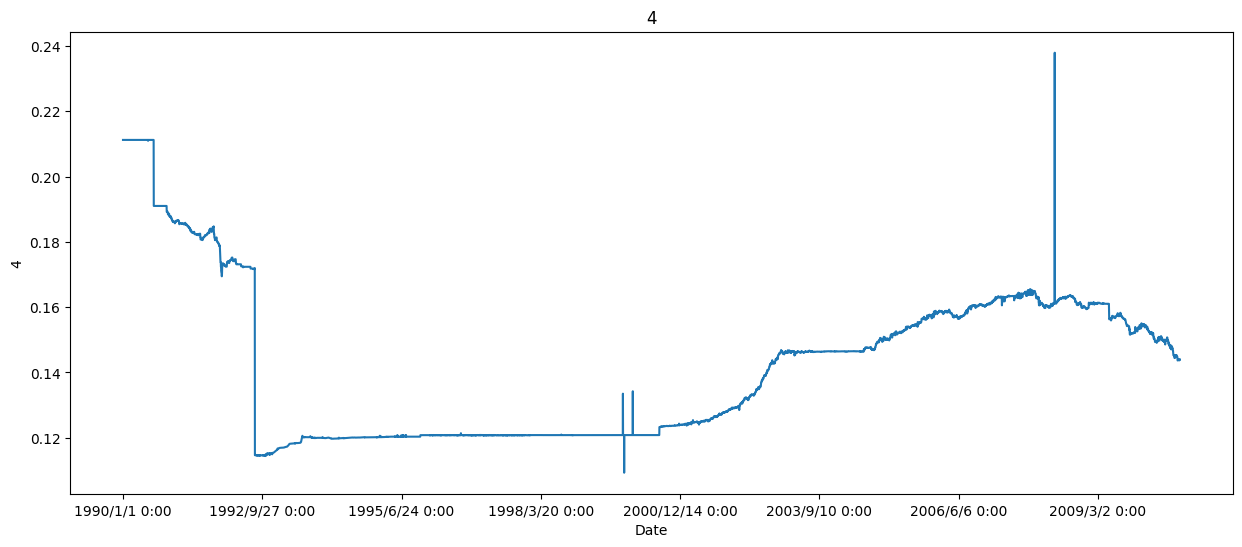

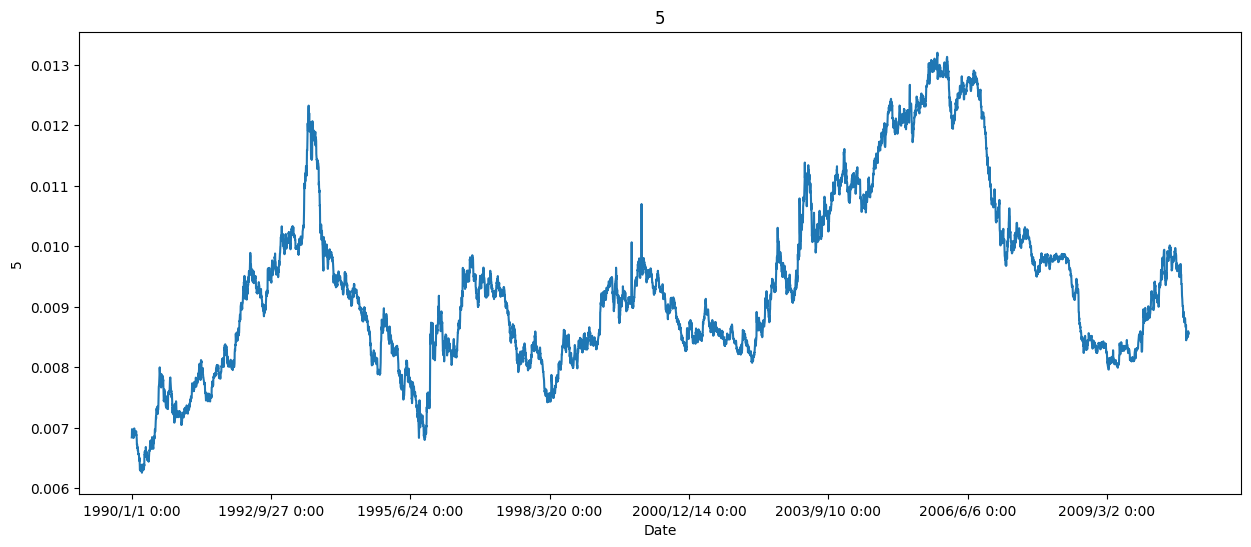

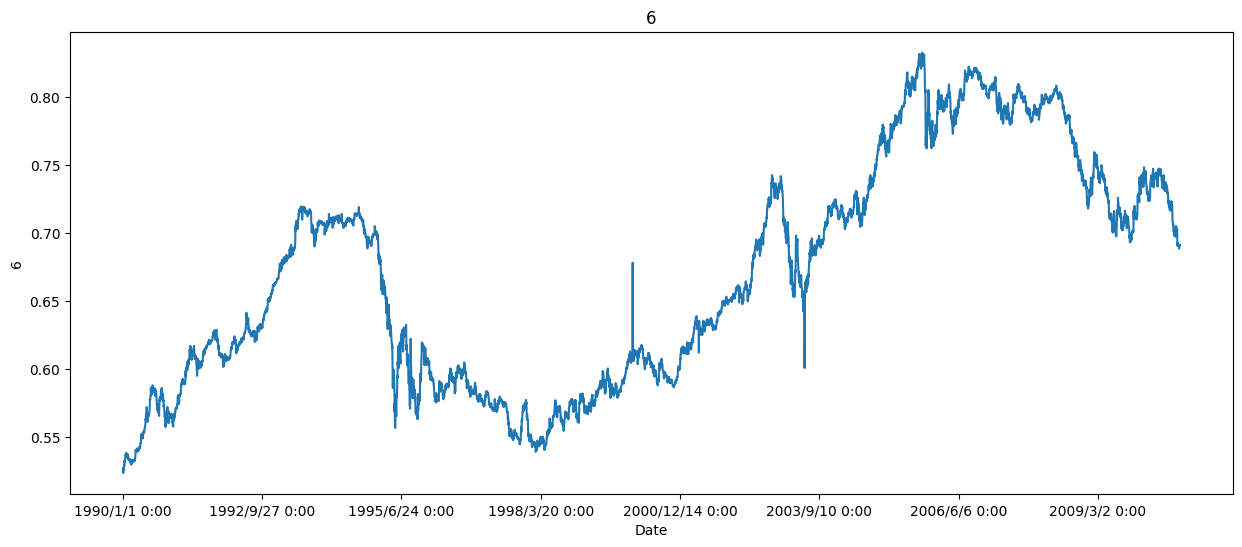

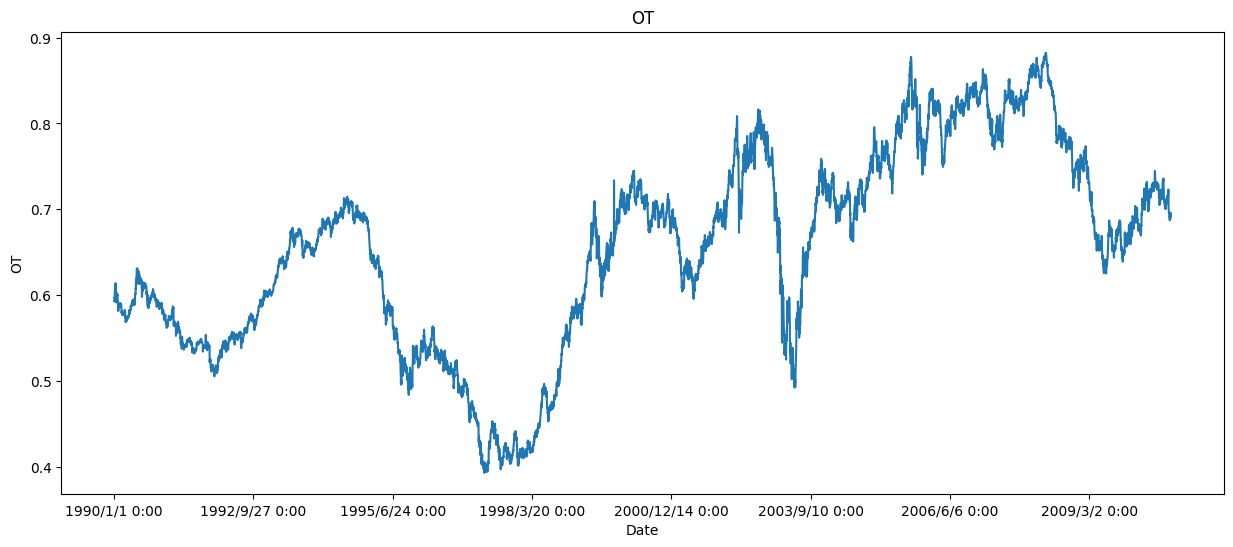

In [ ]:
for feature in df_raw.columns:
    df_raw[str(feature)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)}")
    plt.show()

## Check for stationarity

In [ ]:
for name, column in df_raw[['0', '1', '2', '3', '4', '5', '6', 'OT']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df_raw[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: 0
ADF Test Statistic        -1.664994
P-Value                    0.449233
# Lags Used                1.000000
# Observations Used     7586.000000
Critical Value (1%)       -3.431212
Critical Value (5%)       -2.861921
Critical Value (10%)      -2.566973
dtype: float64

Conclusion:
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: 1
ADF Test Statistic        -2.149718
P-Value                    0.224998
# Lags Used               14.000000
# Observations Used     7573.000000
Critical Value (1%)       -3.431214
Critical Value (5%)       -2.861922
Critical Value (10%)      -2.566973
dtype: float64

Conclusion:
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: 2
ADF Test Statistic        -1.352572
P-Value                    0.604791
# Lags Used                7.000000
# Observations Used     7580.000000
Critical Value (1%)       -3.431213
Critical

## Split into Train and Test

In [ ]:
X = df_raw.copy()

pred_len = [96, 192, 336, 720]

train, test = time_train_test_split(X, test_size=pred_len[0])

## Make it stationary

In [ ]:
train_diff = train.diff()
train_diff.iloc[0] = train.iloc[0]

In [ ]:
for name, column in train_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

## Cointegreation test

In [ ]:
cointegration_test_func(train_diff)

## Hyperparameter tuning

In [ ]:
def find_order_auto_arima(X):
  print(f'Searching order of p and q for : OT')
  stepwise_model = auto_arima(X['OT'],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
      trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
  parameter = stepwise_model.get_params().get('order')
  print(f'optimal order for: OT is: {parameter} \n\n')
  return stepwise_model.get_params().get('order')

In [ ]:
def find_order_param_grid(X, y):
  param_grid = {'p': [1,2,3], 'q':[1,2,3]}
  pg = list(ParameterGrid(param_grid))

  df_results = pd.DataFrame(columns=['p', 'q','mae','mse'])
  print('Starting grid search...')
  for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    if (p==2 and q==1) or (p==1 and q==2):
      pass
    else:
      print(f'Order: p={p}, q={q}')
      model_fit = VARMAX(X, order=(p,q)).fit()
      result = model_fit.forecast(len(y))

      mae = mean_absolute_error(y['OT'], result['OT'])
      mse = mean_squared_error(y['OT'], result['OT'])

      df_results = df_results.append({'p': p, 'q': q, 'mae': mae, 'mse': mse}, ignore_index=True)

  return list(df_results.sort_values('mae', ascending=True)[['p', 'q']].iloc[0])

In [ ]:
def find_order_param_grid_diff(X, y):
  param_grid = {'p': [1,2,3], 'q':[1,2,3]}
  pg = list(ParameterGrid(param_grid))

  df_results = pd.DataFrame(columns=['p', 'q','mae','mse'])
  print('Starting grid search...')
  for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    if (p==2 and q==3):
      pass
    else:
      print(f'Order: p={p}, q={q}')
      model_fit = VARMAX(X, order=(p,q)).fit()
      result = model_fit.forecast(len(y))

      df_pred = pd.DataFrame(result, columns=train.columns)

      df_pred["new_index"] = range(len(X), len(df_raw))
      df_pred = df_pred.set_index("new_index")

      res = inverse_diff_func(X, df_pred)

      mae = mean_absolute_error(y['OT'] , res['OT_inv_diff'])
      mse = mean_squared_error(y['OT'], res['OT_inv_diff'])

      df_results = df_results.append({'p': p, 'q': q, 'mae': mae, 'mse': mse}, ignore_index=True)

  return list(df_results.sort_values('mae', ascending=True)[['p', 'q']].iloc[0])

In [ ]:
optimal_order1 = find_order_auto_arima(train_diff) 
optimal_order2 = find_order_param_grid(train_diff, test)  

Searching order of p and q for : OT
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-50341.823, Time=1.84 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-50340.228, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-50341.303, Time=1.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-50343.560, Time=1.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-50341.637, Time=2.87 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-50339.576, Time=4.38 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-50342.578, Time=4.53 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 16.281 seconds
optimal order for: OT is: (0, 0, 1) 


Starting grid search...
Order: p=1, q=1
Order: p=1, q=3
Order: p=2, q=2
Order: p=2, q=3
Order: p=3, q=1
Order: p=3, q=2
Order: p=3, q=3


In [ ]:
optimal_order3 = find_order_auto_arima(train) 
optimal_order4 = find_order_param_grid(train, test)  

Searching order of p and q for : OT
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-58516.959, Time=3.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58502.135, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58518.958, Time=1.56 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58518.947, Time=2.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58504.032, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-58516.958, Time=2.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-58496.118, Time=3.98 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-58520.845, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-58518.845, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-58518.846, Time=2.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58520.833, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-58498.028, Time=1.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 21.163 seconds
optimal order for: OT is: (

In [ ]:
print(f'Order (AutoARIMA, difference): {optimal_order1}')
print(f'Order (GridSearch, difference): {optimal_order2}')
print(f'Order (AutoARIMA, non-difference): {optimal_order3}')
print(f'Order (GridSearch, non-difference): {optimal_order4}')

Order (AutoARIMA, difference): (0, 0, 1)
Order (GridSearch, difference): [3.0, 2.0]
Order (AutoARIMA, non-difference): (1, 1, 0)
Order (GridSearch, non-difference): [1.0, 3.0]


## Fit model

In [ ]:
model1 = VARMAX(train_diff, order=(optimal_order1[0], optimal_order1[2])).fit(disp=False)
model2 = VARMAX(train_diff, order=optimal_order2).fit(disp=False)
model3 = VARMAX(train, order=(optimal_order3[0], optimal_order1[2])).fit(disp=False)
model4 = VARMAX(train, order=optimal_order4).fit(disp=False)

In [ ]:
result1 = model1.forecast(steps = len(test))
result2 = model2.forecast(steps = len(test))

# Difference 
df_pred1 = pd.DataFrame(result1, columns=train_diff.columns)
df_pred2 = pd.DataFrame(result2, columns=train_diff.columns)


df_pred1["new_index"] = range(len(train), len(X))
df_pred2["new_index"] = range(len(train), len(X))

df_pred1 = df_pred1.set_index("new_index")
df_pred2 = df_pred2.set_index("new_index")

res1 = inverse_diff_func(train, df_pred1)
res2 = inverse_diff_func(train, df_pred2)

print('Difference:')

print(f'AutoARIMA:')
print(f'Evaluation metric for OT:')
timeseries_evaluation_metrics_func(test['OT'] , res1['OT_inv_diff'])

print(f'GridSearch:')
print(f'Evaluation metric for OT:')
timeseries_evaluation_metrics_func(test['OT'] , res2['OT_inv_diff'])

Difference:
AutoARIMA:
Evaluation metric for OT:
Evaluation metric results: 
MAE is : 0.02166416666769894
MSE is : 0.0006559787007074254
RMSE is : 0.02561208114752539
MAPE is : 3.0789940163954848
R2 is : -3.4907822780360283

GridSearch:
Evaluation metric for OT:
Evaluation metric results: 
MAE is : 0.021843243637594798
MSE is : 0.0006715689610407306
RMSE is : 0.02591464761560015
MAPE is : 3.104757869756993
R2 is : -3.59751206170015



In [ ]:
result3 = model3.forecast(steps = len(test))
result4 = model4.forecast(steps = len(test))

print('Non-Difference')

print(f'AutoARIMA:')
print(f'Evaluation metric for OT:')
timeseries_evaluation_metrics_func(test['OT'] , result3['OT'])

print(f'GridSearch:')
print(f'Evaluation metric for OT:')
timeseries_evaluation_metrics_func(test['OT'] , result4['OT'])

Non-Difference
AutoARIMA:
Evaluation metric for OT:
Evaluation metric results: 
MAE is : 0.021352931942425515
MSE is : 0.0006399097459786331
RMSE is : 0.025296437416731887
MAPE is : 3.0349531240880525
R2 is : -3.3807753875000977

GridSearch:
Evaluation metric for OT:
Evaluation metric results: 
MAE is : 0.021228085094761314
MSE is : 0.0006339492291938488
RMSE is : 0.0251783484206937
MAPE is : 3.0173147316679567
R2 is : -3.3399701248960234



In [ ]:
results = pd.read_csv('/content/results_VARMA_raw_exchange_rate.csv')
#/content/results_VARMA_diff_exchange_rate.csv for differenced data

In [ ]:
results.columns

Index(['0', '1', '2', '3', '4', '5', '6', 'OT', 'forecast_96', 'residuals_96',
       'forecast_192', 'residuals_192', 'forecast_336', 'residuals_336',
       'forecast_720', 'residuals_720'],
      dtype='object')

In [ ]:
# Add best df to ILI data
results['date'] = df_raw.index
residual_df = results[['date', '0', '1', '2', '3', '4', '5', '6', 'residuals_192', 'OT']].rename(columns={'residuals_192': 'RESIDUALS'})
all_residual_df = results[['date', '0', '1', '2', '3', '4', '5', '6', 'residuals_96', 'residuals_192', 'residuals_336', 'residuals_720', 'OT']]

residual_df

residual_df.to_csv("exchange_rate_VARMA_Residuals.csv", index=False)

In [ ]:
residual_df

,date,0,1,2,3,4,5,6,residuals_192,OT
0,1990/1/1 0:00,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,-0.059815,0.593000
1,1990/1/2 0:00,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,0.001218,0.594000
2,1990/1/3 0:00,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,0.003523,0.597300
3,1990/1/4 0:00,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,-0.000092,0.597000
4,1990/1/5 0:00,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.527426,0.001698,0.598500
...,...,...,...,...,...,...,...,...,...,...
7583,2010/10/6 0:00,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.688565,-0.028493,0.690846
7584,2010/10/7 0:00,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.690288,-0.023644,0.695701
7585,2010/10/8 0:00,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.691419,-0.023409,0.695943
7586,2010/10/9 0:00,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.690942,-0.026669,0.692689


In [ ]:
residual_df.to_csv("exchange_rate_VARMA_Residuals.csv", index=False)

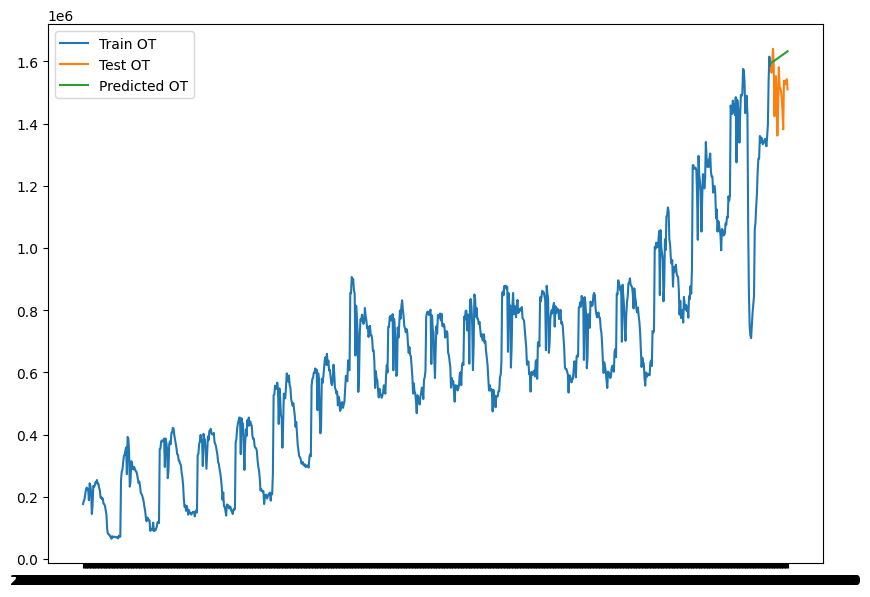

In [ ]:
plt.rcParams["figure.figsize"] = [10,7]
plt.plot(train['OT'], label='Train OT')
plt.plot(test['OT'], label='Test OT')
plt.plot(res1['OT_inv_diff'], label='Predicted OT')
plt.legend(loc='best')
plt.show()

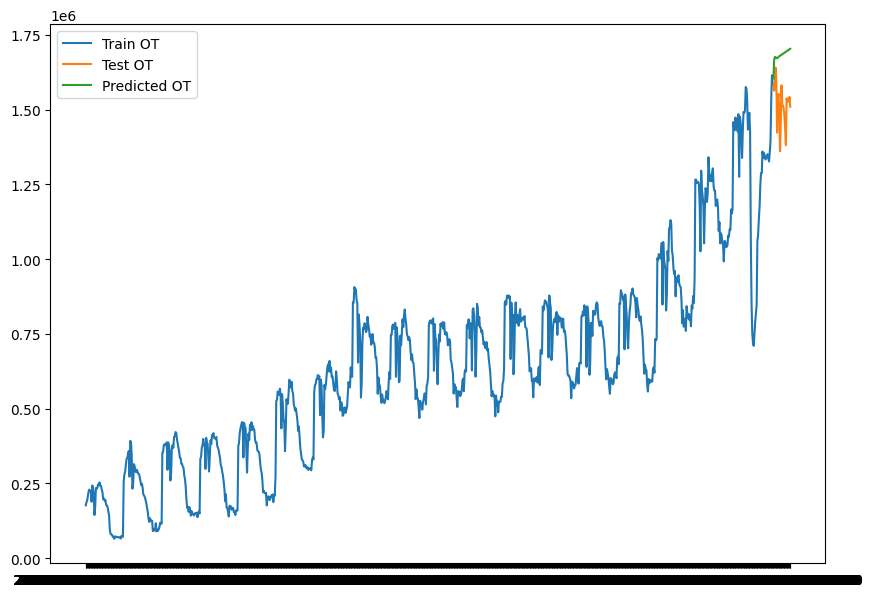

In [ ]:
plt.rcParams["figure.figsize"] = [10,7]
plt.plot(train['OT'], label='Train OT')
plt.plot(test['OT'], label='Test OT')
plt.plot(res2['OT_inv_diff'], label='Predicted OT')
plt.legend(loc='best')
plt.show()